# Siamese Network with a contrastive loss

In [1]:
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (8, 5)})

### Dataset

In [2]:
data = fetch_olivetti_faces()

images_dataset = data['images']
labels_dataset = data['target']

X = pd.DataFrame(images_dataset.reshape(400, 64*64))
y = pd.Series(labels_dataset)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.3)

train_images = X_train.values.reshape(X_train.shape[0], 64, 64)
test_images = X_test.values.reshape(X_test.shape[0], 64, 64)

train_labels = y_train.values
test_labels = y_test.values

train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                      stratify=train_labels, random_state=0,
                                                                      test_size=0.2)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


### Create pairs of images

In [3]:
def create_sample_pairs(x, y):

  pairs = list()
  labels = list()

  for i in range(len(x)-1):
    for j in range(i, len(x)):
      pairs += [[x[i], x[j]]]
      if y[i] == y[j]:
        labels += [1]
      else:
        labels += [0]

  return np.array(pairs), np.array(labels).astype('float32')

In [4]:
pairs_train, labels_train = create_sample_pairs(train_images, train_labels)
pairs_val, labels_val = create_sample_pairs(val_images, val_labels)
pairs_test, labels_test = create_sample_pairs(test_images, test_labels)

In [5]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [6]:
pairs_train.shape

(25199, 2, 64, 64)

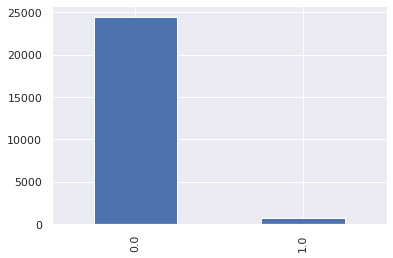

In [7]:
pd.Series(labels_train).value_counts().plot(kind='bar');

### Visualize pairs and their labels

In [8]:

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()


Train pairs

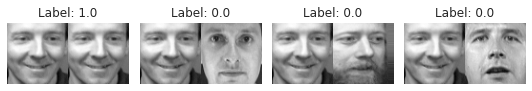

In [9]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

Test pairs

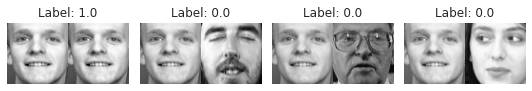

In [10]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

### Define the constrastive Loss

In [19]:
def loss(margin=1):

    def contrastive_loss(y_true, y_pred):

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


### Performance visualization

In [20]:
def plt_metric(history, metric, title, has_valid=True):
   
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

In [21]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Model 1

In [23]:
def create_model_1():
  input = layers.Input((64, 64, 1))
  x = tf.keras.layers.BatchNormalization()(input)
  x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)

  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dense(20, activation="tanh")(x)
  embedding_network = keras.Model(input, x)


  input_1 = layers.Input((64, 64, 1))
  input_2 = layers.Input((64, 64, 1))

  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

  return siamese

In [24]:
epochs = 25
batch_size = 32
margin = 1  # Margin for constrastive loss.

siamese_1 = create_model_1()

opt = optimizers.RMSprop(learning_rate=0.0001)
siamese_1.compile(loss=loss(margin=margin), optimizer=opt, metrics=['accuracy', f1_m])
siamese_1.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 20)           71752       ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

In [25]:
history_1 = siamese_1.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/25
788/788 [==============================] - 17s 17ms/step - loss: 0.2505 - accuracy: 0.6453 - f1_m: 0.1383 - val_loss: 0.2240 - val_accuracy: 0.6947 - val_f1_m: 0.2254
Epoch 2/25
788/788 [==============================] - 13s 16ms/step - loss: 0.1961 - accuracy: 0.7713 - f1_m: 0.2015 - val_loss: 0.2046 - val_accuracy: 0.7310 - val_f1_m: 0.2567
Epoch 3/25
788/788 [==============================] - 13s 16ms/step - loss: 0.1593 - accuracy: 0.8422 - f1_m: 0.2568 - val_loss: 0.1691 - val_accuracy: 0.8019 - val_f1_m: 0.3150
Epoch 4/25
788/788 [==============================] - 13s 16ms/step - loss: 0.1298 - accuracy: 0.8846 - f1_m: 0.3102 - val_loss: 0.1463 - val_accuracy: 0.8514 - val_f1_m: 0.3722
Epoch 5/25
788/788 [==============================] - 13s 16ms/step - loss: 0.1052 - accuracy: 0.9121 - f1_m: 0.3560 - val_loss: 0.1158 - val_accuracy: 0.8897 - val_f1_m: 0.4499
Epoch 6/25
788/788 [==============================] - 13s 16ms/step - loss: 0.0844 - accuracy: 0.9308 - f1_m: 

### Model 1 results

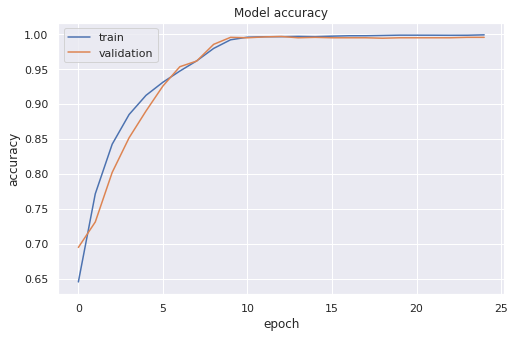

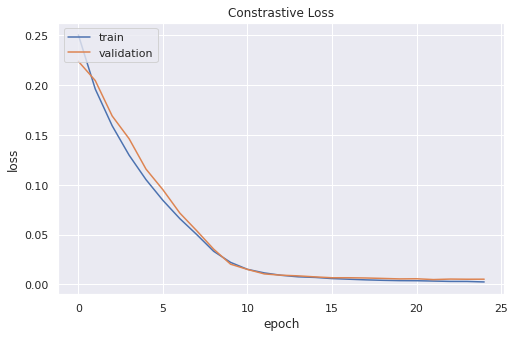

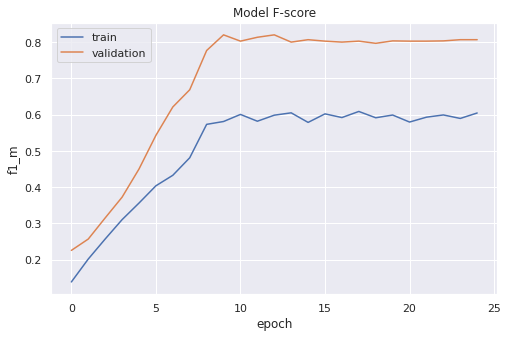

In [26]:
plt_metric(history=history_1.history, metric="accuracy", title="Model accuracy")

plt_metric(history=history_1.history, metric="loss", title="Constrastive Loss")

plt_metric(history=history_1.history, metric="f1_m", title="Model F-score")

### Evaluate the model 1

In [18]:
results = siamese_1.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

227/227 [==============================] - 2s 8ms/step - loss: 0.0052 - accuracy: 0.9953 - f1_m: 0.6216
test loss, test acc: [0.005220918450504541, 0.9953161478042603, 0.6216488480567932]


### Visualize model 1 results

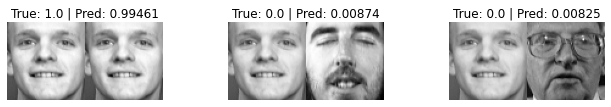

In [19]:
predictions_1 = siamese_1.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions_1, test=True)

In [20]:
print(classification_report(labels_test.astype('int'), predictions_1.round().astype('int')))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7020
           1       0.99      0.87      0.92       239

    accuracy                           1.00      7259
   macro avg       0.99      0.93      0.96      7259
weighted avg       1.00      1.00      1.00      7259



# Data augmentation

### Undersampling

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [13]:
under = RandomUnderSampler(sampling_strategy='majority')
undersampled_pairs_train, undersampled_labels_train = under.fit_resample(pairs_train.reshape(pairs_train.shape[0], 2*64*64), labels_train)
undersampled_pairs_val, undersampled_labels_val = under.fit_resample(pairs_val.reshape(pairs_val.shape[0], 2*64*64), labels_val)
undersampled_pairs_test, undersampled_labels_test = under.fit_resample(pairs_test.reshape(pairs_test.shape[0], 2*64*64), labels_test)

undersampled_pairs_train = undersampled_pairs_train.reshape(undersampled_pairs_train.shape[0], 2, 64, 64)
undersampled_pairs_val = undersampled_pairs_val.reshape(undersampled_pairs_val.shape[0], 2, 64, 64)
undersampled_pairs_test = undersampled_pairs_test.reshape(undersampled_pairs_test.shape[0], 2, 64, 64)

undersampled_x_train_1 = undersampled_pairs_train[:, 0]
undersampled_x_train_2 = undersampled_pairs_train[:, 1]

undersampled_x_val_1 = undersampled_pairs_val[:, 0]
undersampled_x_val_2 = undersampled_pairs_val[:, 1]

undersampled_x_test_1 = undersampled_pairs_test[:, 0]
undersampled_x_test_2 = undersampled_pairs_test[:, 1]

## Model 2

In [75]:
def create_model_2():
  input = layers.Input((64, 64, 1))
  x = tf.keras.layers.BatchNormalization()(input)
  x = layers.Conv2D(8, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dense(24, activation="tanh")(x)
  embedding_network = keras.Model(input, x)


  input_1 = layers.Input((64, 64, 1))
  input_2 = layers.Input((64, 64, 1))

  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

  return siamese

In [76]:
epochs = 30
batch_size = 256
margin = 1  # Margin for constrastive loss.

siamese_2 = create_model_2()

opt = optimizers.RMSprop(learning_rate=0.001)
siamese_2.compile(loss=loss(margin=margin), optimizer=opt, metrics=['accuracy', f1_m])
siamese_2.summary()


Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_20 (Functional)          (None, 24)           79164       ['input_32[0][0]',               
                                                                  'input_33[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 1)            0           ['model_20[0][0]',        

In [77]:
history_2 = siamese_2.fit(
    [undersampled_x_train_1, undersampled_x_train_2],
    undersampled_labels_train,
    validation_data=([undersampled_x_val_1, undersampled_x_val_2], undersampled_labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/30
6/6 [==============================] - 3s 161ms/step - loss: 0.1948 - accuracy: 0.7429 - f1_m: 0.7445 - val_loss: 0.2127 - val_accuracy: 0.9085 - val_f1_m: 0.9023
Epoch 2/30
6/6 [==============================] - 0s 67ms/step - loss: 0.1686 - accuracy: 0.8419 - f1_m: 0.8449 - val_loss: 0.2009 - val_accuracy: 0.9085 - val_f1_m: 0.9103
Epoch 3/30
6/6 [==============================] - 0s 62ms/step - loss: 0.1605 - accuracy: 0.8620 - f1_m: 0.8637 - val_loss: 0.1876 - val_accuracy: 0.8944 - val_f1_m: 0.9007
Epoch 4/30
6/6 [==============================] - 0s 63ms/step - loss: 0.1550 - accuracy: 0.8883 - f1_m: 0.8911 - val_loss: 0.1771 - val_accuracy: 0.8732 - val_f1_m: 0.8846
Epoch 5/30
6/6 [==============================] - 0s 61ms/step - loss: 0.1483 - accuracy: 0.9145 - f1_m: 0.9149 - val_loss: 0.1633 - val_accuracy: 0.8873 - val_f1_m: 0.8961
Epoch 6/30
6/6 [==============================] - 0s 64ms/step - loss: 0.1471 - accuracy: 0.9152 - f1_m: 0.9163 - val_loss: 0.1535 - v

### Model 2 results

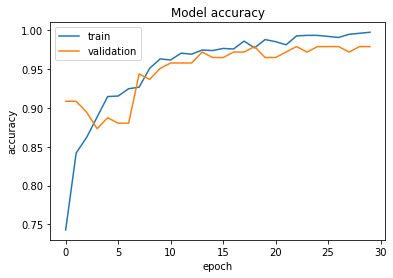

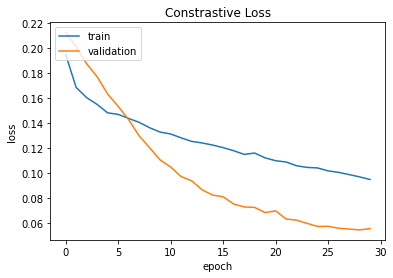

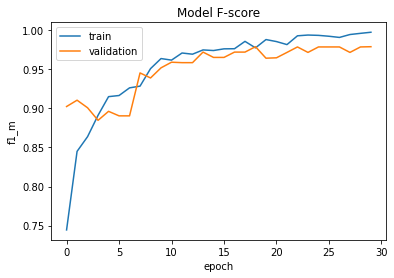

In [82]:
plt_metric(history=history_2.history, metric="accuracy", title="Model accuracy")

plt_metric(history=history_2.history, metric="loss", title="Constrastive Loss")

plt_metric(history=history_2.history, metric="f1_m", title="Model F-score")

### Evaluate the model 2

In [79]:
results = siamese_2.evaluate([undersampled_x_test_1, undersampled_x_test_2], undersampled_labels_test)
print("test loss, test acc:", results)

15/15 [==============================] - 0s 7ms/step - loss: 0.0774 - accuracy: 0.9477 - f1_m: 0.5062
test loss, test acc: [0.07736644148826599, 0.9476987719535828, 0.5062177777290344]


### Visualize model 2 results

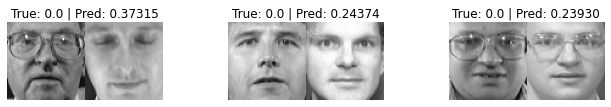

In [80]:
predictions_2 = siamese_2.predict([undersampled_x_test_1, undersampled_x_test_2])
visualize(undersampled_pairs_test, undersampled_labels_test, to_show=3, predictions=predictions_2, test=True)

In [81]:
print(classification_report(undersampled_labels_test.astype('int'), predictions_2.round().astype('int')))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       239
           1       0.97      0.92      0.95       239

    accuracy                           0.95       478
   macro avg       0.95      0.95      0.95       478
weighted avg       0.95      0.95      0.95       478



### Oversampling

In [14]:
over = RandomOverSampler(sampling_strategy='minority')
oversampled_pairs_train, oversampled_labels_train = over.fit_resample(pairs_train.reshape(pairs_train.shape[0], 2*64*64), labels_train)
oversampled_pairs_val, oversampled_labels_val = over.fit_resample(pairs_val.reshape(pairs_val.shape[0], 2*64*64), labels_val)
oversampled_pairs_test, oversampled_labels_test = over.fit_resample(pairs_test.reshape(pairs_test.shape[0], 2*64*64), labels_test)

oversampled_pairs_train = oversampled_pairs_train.reshape(oversampled_pairs_train.shape[0], 2, 64, 64)
oversampled_pairs_val = oversampled_pairs_val.reshape(oversampled_pairs_val.shape[0], 2, 64, 64)
oversampled_pairs_test = oversampled_pairs_test.reshape(oversampled_pairs_test.shape[0], 2, 64, 64)

oversampled_x_train_1 = oversampled_pairs_train[:, 0]
oversampled_x_train_2 = oversampled_pairs_train[:, 1]

oversampled_x_val_1 = oversampled_pairs_val[:, 0]
oversampled_x_val_2 = oversampled_pairs_val[:, 1]

oversampled_x_test_1 = oversampled_pairs_test[:, 0]
oversampled_x_test_2 = oversampled_pairs_test[:, 1]

## Model 3

In [30]:
def create_model_3():
  input = layers.Input((64, 64, 1))
  x = tf.keras.layers.BatchNormalization()(input)
  x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv2D(8, (5, 5), activation="tanh")(x)
  x = layers.AveragePooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = layers.Dense(24, activation="tanh")(x)
  embedding_network = keras.Model(input, x)


  input_1 = layers.Input((64, 64, 1))
  input_2 = layers.Input((64, 64, 1))

  tower_1 = embedding_network(input_1)
  tower_2 = embedding_network(input_2)

  merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
  normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
  output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
  siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

  return siamese

In [31]:
epochs = 20
batch_size = 256
margin = 1  # Margin for constrastive loss.

siamese_3 = create_model_3()

opt = optimizers.RMSprop(learning_rate=0.001)
siamese_3.compile(loss=loss(margin=margin), optimizer=opt, metrics=['accuracy', f1_m])
siamese_3.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_6 (Functional)           (None, 24)           38796       ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['model_6[0][0]',          

In [32]:
history_3 = siamese_3.fit(
    [oversampled_x_train_1, oversampled_x_train_2],
    oversampled_labels_train,
    validation_data=([oversampled_x_val_1, oversampled_x_val_2], oversampled_labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/20
192/192 [==============================] - 11s 43ms/step - loss: 0.2508 - accuracy: 0.4909 - f1_m: 0.5311 - val_loss: 0.2310 - val_accuracy: 0.8176 - val_f1_m: 0.5781
Epoch 2/20
192/192 [==============================] - 8s 40ms/step - loss: 0.2229 - accuracy: 0.9115 - f1_m: 0.9127 - val_loss: 0.1646 - val_accuracy: 0.9557 - val_f1_m: 0.7584
Epoch 3/20
192/192 [==============================] - 8s 40ms/step - loss: 0.1712 - accuracy: 0.9733 - f1_m: 0.9736 - val_loss: 0.1140 - val_accuracy: 0.9642 - val_f1_m: 0.7906
Epoch 4/20
192/192 [==============================] - 8s 40ms/step - loss: 0.1194 - accuracy: 0.9851 - f1_m: 0.9849 - val_loss: 0.0767 - val_accuracy: 0.9688 - val_f1_m: 0.8412
Epoch 5/20
192/192 [==============================] - 8s 40ms/step - loss: 0.0764 - accuracy: 0.9906 - f1_m: 0.9902 - val_loss: 0.0502 - val_accuracy: 0.9780 - val_f1_m: 0.9068
Epoch 6/20
192/192 [==============================] - 8s 40ms/step - loss: 0.0453 - accuracy: 0.9944 - f1_m: 0.994

### Model 3 results

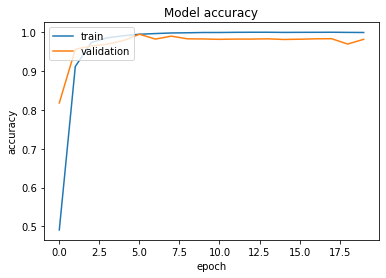

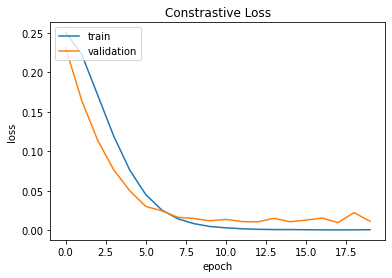

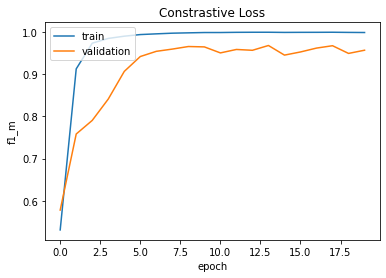

In [35]:
plt_metric(history=history_3.history, metric="accuracy", title="Model accuracy")

plt_metric(history=history_3.history, metric="loss", title="Constrastive Loss")

plt_metric(history=history_3.history, metric="f1_m", title="Model F-score")

### Evaluate the model 3

In [36]:
results = siamese_3.evaluate([oversampled_x_test_1, oversampled_x_test_2], oversampled_labels_test)
print("test loss, test acc:", results)

439/439 [==============================] - 3s 7ms/step - loss: 0.0281 - accuracy: 0.9645 - f1_m: 0.7986
test loss, test acc: [0.02814011089503765, 0.9645299315452576, 0.7986403107643127]


### Visualize model 3 results

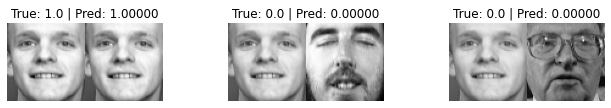

In [37]:
predictions_3 = siamese_3.predict([oversampled_x_test_1, oversampled_x_test_2])
visualize(oversampled_pairs_test, oversampled_labels_test, to_show=3, predictions=predictions_3, test=True)

In [38]:
print(classification_report(oversampled_labels_test.astype('int'), predictions_3.round().astype('int')))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      7020
           1       0.99      0.94      0.96      7020

    accuracy                           0.96     14040
   macro avg       0.97      0.96      0.96     14040
weighted avg       0.97      0.96      0.96     14040

